In [1]:
import sys
import os
import pandas as pd
import numpy as np

from KirschNowak import KirschNowakGenerator
from utils.transform import transform_timeseries_df_to_ndarray
from validation.diagnostic_plots import plot_flow_ranges, plot_fdc_ranges, plot_correlation_heatmap
from validation.autocorrelation import plot_autocorrelation


# source flow used for generation
src_flow = 'obs_pub_nhmv10_ObsScaled'
src_file = f'../input_data/catchment_inflow_{src_flow}.csv'

# check the file exists
assert(os.path.exists(src_file)), f"Flow data {src_flow} does not exist at location {src_file}"

# load inflow data
Qh_df = pd.read_csv(f'../input_data/catchment_inflow_{src_flow}.csv', 
                    index_col=0, parse_dates=True)
Qh_df.index.freq = 'D'

# drop delTrenton (this will be the same flow as delDRCanal in the end)
Qh_df.drop(columns=['delTrenton'], inplace=True)

datetime = Qh_df.index
sites = Qh_df.columns.to_list()
Qh_np = Qh_df.to_numpy()


# Constants
N_REALIZATIONS = 100
N_DAYS_PER_MONTH = 31
N_DAYS_HIST, N_SITES = Qh_df.shape
N_YEARS_HIST = int(N_DAYS_HIST/365) 
N_YEARS_SYN = N_YEARS_HIST - 1


# Initialize model
model = KirschNowakGenerator(Qh_df,
                             matrix_repair_method = 'spectral',
                             generate_using_log_flow = True)

Q_sde, Q_sme = model.generate_ensemble(N_REALIZATIONS, return_monthly_data = True)

Q_syn = Q_sde.reshape((N_REALIZATIONS, N_SITES, (N_YEARS_SYN * 365)))

(100, 30, 77, 365)

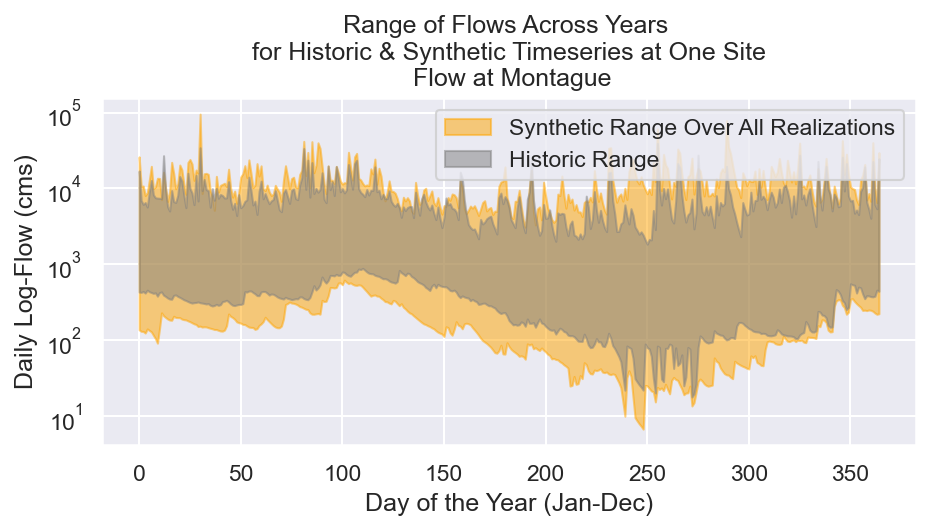

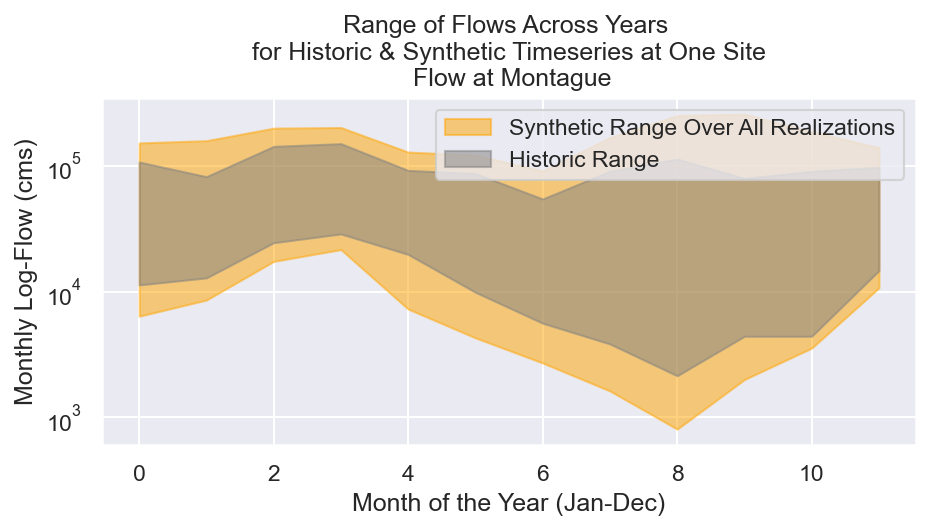

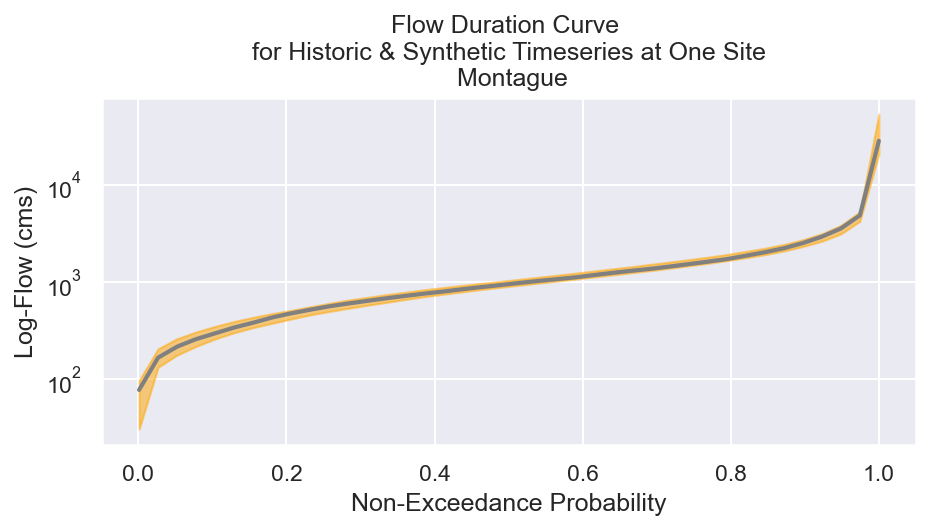

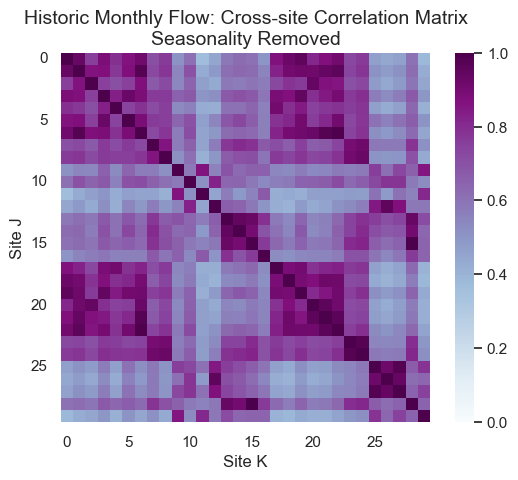

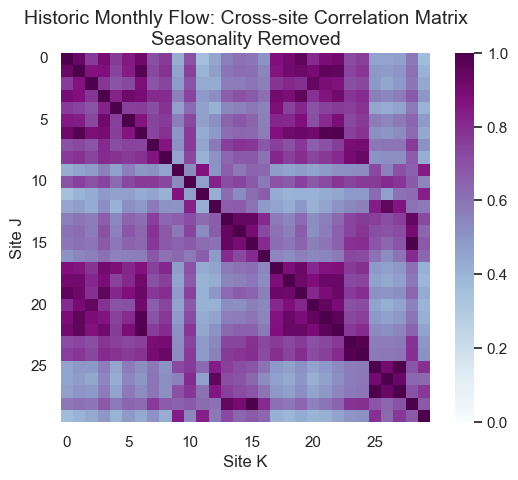

<module 'matplotlib.pyplot' from 'c:\\Users\\tjame\\Desktop\\Research\\DRB\\Pywr-DRB\\Pywr-DRB\\win_venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [36]:
# Choose site of interest
plot_site = 'delMontague'
site_no = Qh_df.columns.get_loc(plot_site)


Qh_long = transform_timeseries_df_to_ndarray(Qh_df)
plot_flow_ranges(Qh_long, model.Q_sde, y_scale = 'log', site = site_no, 
                 title_addon='Flow at Montague')

Q_hm3d = model.Q_hm_3d
plot_flow_ranges(Q_hm3d, Q_sme, y_scale = 'log', site = site_no, 
                 title_addon='Flow at Montague')

plot_fdc_ranges(Qh_long, model.Q_sde, site=site_no,
                        title_addon='Montague')


# Calculate historic and synthetic cross-site correlations
hist_site_correlation = np.corrcoef(Qh_np.transpose())
syn_site_correlation = np.corrcoef(Q_syn[0,:,:])

# Visualize
plot_correlation_heatmap(hist_site_correlation)
plot_correlation_heatmap(syn_site_correlation)